## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/mcapetz/Downloads/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [5]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)


In [6]:
print(loss)

2.327760702804897


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

We take the log likelihood of 0.10 because the weights are randomly initialized, we take -log(0.10) which is close to 2.3, which makes sense.

#### Softmax gradient

In [7]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

for loop loss 2.3383493557745996
numerical: -0.542683 analytic: -0.542683, relative error: 6.983491e-08
numerical: -0.293379 analytic: -0.293379, relative error: 5.650900e-09
numerical: -0.268456 analytic: -0.268456, relative error: 9.019206e-08
numerical: 1.603418 analytic: 1.603418, relative error: 1.557917e-08
numerical: 0.957375 analytic: 0.957375, relative error: 1.202059e-08
numerical: 2.325052 analytic: 2.325052, relative error: 4.799397e-10
numerical: -0.072500 analytic: -0.072500, relative error: 4.240652e-07
numerical: 0.614202 analytic: 0.614202, relative error: 3.688366e-08
numerical: -0.597377 analytic: -0.597377, relative error: 1.051529e-09
numerical: -2.759162 analytic: -2.759162, relative error: 2.466011e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [8]:
import time

In [9]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
#print(grad.shape)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
print("****",loss_vectorized.shape, grad_vectorized.shape)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

for loop loss 2.3383493557745996
Normal loss / grad_norm: 2.3383493557745996 / 341.31254890164223 computed in 0.038594961166381836s
**** () (10, 3073)
Vectorized loss / grad: 2.3383493557745996 / 341.31254890164223 computed in 0.006170749664306641s
difference in loss / grad: 0.0 /2.2885802908952907e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.335383545089155
iteration 100 / 1500: loss 2.0225093946317187
iteration 200 / 1500: loss 1.982172871654982
iteration 300 / 1500: loss 1.9356442081331482
iteration 400 / 1500: loss 1.882893396815689
iteration 500 / 1500: loss 1.8181869697394497
iteration 600 / 1500: loss 1.874513153185746
iteration 700 / 1500: loss 1.836183250017359
iteration 800 / 1500: loss 1.8584086819212182
iteration 900 / 1500: loss 1.9275087067564147
iteration 1000 / 1500: loss 1.824667969507725
iteration 1100 / 1500: loss 1.7731817984393603
iteration 1200 / 1500: loss 1.8636308568113116
iteration 1300 / 1500: loss 1.924074621260815
iteration 1400 / 1500: loss 1.7846918635831293
That took 5.443572998046875s


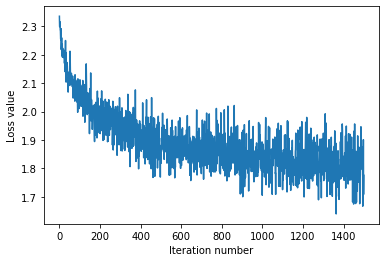

In [20]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [33]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.37881632653061226
validation accuracy: 0.39


## Optimize the softmax classifier

In [ ]:
np.finfo(float).eps

In [39]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

rates = [1e-5, 1e-6, 1e-7]

print("rates")

for rate in rates:
    print(rate)

    loss_hist = softmax.train(X_train, y_train, learning_rate=rate,num_iters=1500, verbose=False)
    y_train_pred = softmax.predict(X_train)
    print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
    y_val_pred = softmax.predict(X_val)
    print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

iters = [1400, 1500, 1600, 1700, 1800]

print("iters")

for iter in iters:
    print(iter)
    loss_hist = softmax.train(X_train, y_train, learning_rate=rate,num_iters=iter, verbose=False)
    y_train_pred = softmax.predict(X_train)
    print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
    y_val_pred = softmax.predict(X_val)
    print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

print("ideal")
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-6,num_iters=1700, verbose=False)
y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


rates
1e-05
training accuracy: 0.3072448979591837
validation accuracy: 0.303
1e-06
training accuracy: 0.4217142857142857
validation accuracy: 0.399
1e-07
training accuracy: 0.37951020408163266
validation accuracy: 0.39
iters
1400
training accuracy: 0.38312244897959186
validation accuracy: 0.389
1500
training accuracy: 0.38116326530612243
validation accuracy: 0.389
1600
training accuracy: 0.3826530612244898
validation accuracy: 0.392
1700
training accuracy: 0.38412244897959186
validation accuracy: 0.403
1800
training accuracy: 0.3859591836734694
validation accuracy: 0.397
ideal
training accuracy: 0.4199591836734694
validation accuracy: 0.402


Best learning rate: 1e-6
Best num iterations: 1700

Taken together, I got a 
training accuracy: 0.41996
validation accuracy: 0.402